# Processing and re-formatting plankton-specific marker genes fetched from different sources to create a DB compatible with the powerful MTG-based profiling tool [MetaPhlan](https://github.com/biobakery/MetaPhlAn)   

Importantly, the default reference DB (marker genes derived from ChocoPhlan) used by MetaPhlan is not suitable for profiling marine planktonic ecosystems. Therefore we will create a plankton-specific marker gene DB to quantify relative abundance profiles across taxonomic groups. To achieve this, we will build on two well curated marker gene DBs: 

   - The huge catalog of phytoplankton psbO marker gene sequences, which encodes the manganese-stabilising polypeptide of the photosystem II oxygen evolving complex,  reported in this [paper](https://onlinelibrary.wiley.com/doi/epdf/10.1111/1755-0998.13592) and accessible [here](https://www.ebi.ac.uk/biostudies/studies/S-BSST761?query=A%20robust%20approach%20to%20estimate%20relative%20phytoplankton%20cell%20abundances%20from%20metagenomes). 

   - The [MZGdb](https://metazoogene.org/MZGdb) database and most specifically the "All Plankton Combo" files contain all data from the All Zooplankton and the All Ichthyoplankton combined files. This database was described in this [paper](https://link.springer.com/article/10.1007/s00227-021-03887-y). Here we will focus on DNA sequences for the barcode region of mitochondrial cytochrome oxidase I (COI).

Author: jay@newatlantis.io

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import colorsys
from matplotlib.collections import PatchCollection

import Bio.SeqIO as bioseqio
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
#from Bio.Alphabet import IUPAC
from Bio import Entrez

from ete3 import NCBITaxa
from taxonomy_ranks import TaxonomyRanks

from subprocess import Popen, call, STDOUT, PIPE
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib
import json
import glob
import re
import gzip
import sys
import csv
import time
import io
import pathlib
from collections import OrderedDict

import pickle
import bz2 

from IPython.display import Image
from itertools import combinations
import itertools

In [2]:
matplotlib.rcParams['savefig.dpi'] = 1000
matplotlib.rcParams['figure.dpi'] = 900
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context("paper")
sns.set(font='serif')
sns.set_style('ticks')

### Utility functions

In [ ]:
# *Always* tell NCBI who you are
Entrez.email = "jayson.gutierrez@vliz.be"

In [4]:
def format_tax_lbl(taxid = '94617'):
    """Function to properly format taxonomic labels compatible with MetaPhlan"""
    
    tax_lvls_lbls = ['species','genus','family', 'order', 'class', 'phylum', 'superkingdom'][::-1]
    rank_taxon = TaxonomyRanks(taxid)
    rank_taxon.get_lineage_taxids_and_taxanames()
    rank_dict =  list(rank_taxon.lineages.values())[0]
    tax_tree = list(rank_taxon.lineages.values())[0]
    
    #Parsing info on high rank tanks is optional, but can be quite handy when low ranks are unclassified: for higher rank assignment purposes if needed
    tax_ranks_list = [tax_tree[t][0].replace("NA","unclassified") for t in tax_lvls_lbls]
    ncbi_taxIDs_list = [str(tax_tree[t][1]) for t in tax_lvls_lbls]
    return ncbi_taxIDs_list,tax_ranks_list  


def get_sps_assembly_ncbi_summary(org = "Calanus finmarchicus"):
    '''Function to fetch id_doc_sum for a species NCBI query.
       It returns a Bio.Entrez.Parser.DictionaryElement object if the organism has a genome assembly available
       Otherwise, it returns an empty list
    '''
    search_term = "{}[Orgn]".format(org)
    record = Entrez.read(Entrez.esearch(db="assembly", term=search_term, #prop="complete[prop]"
                                       )
                        )

    #Get ids for target organism, can be multiple depending on taxonomic level
    ids_list = record["IdList"]

    if(len(ids_list)>0):
        #Grab first in list to get info on genome size
        sid = ids_list[0]
        #Query NCBI to fetch data on genome len
        summary_id = Entrez.read(Entrez.esummary(db="assembly",id=sid),validate=False)
        id_doc_sum = summary_id["DocumentSummarySet"]["DocumentSummary"][0]

        # #Inspect fields of dict
        # for k in id_doc_sum.keys():
        #     print("{} : {}".format(k, id_doc_sum[k]))

        return id_doc_sum

    else:
        return []

### Let's explore the resolution of the psbO DB to profile the taxonomic composition of TARA Ocean samples: phytoplankton species 

Let's first check the metadata ...

In [41]:
#Loading data as a DF
psbO_db = '/data/gent/vo/001/gvo00125/vsc43582/Bioinformatics/MetaPhlAn/Data/psbOdb'
psbO_tara_profiling = pd.read_csv(os.path.join(psbO_db,'psbO_mapping_against_Tara_Oceans_metagenomes.tsv'),sep='\t')

In [42]:
psbO_tara_profiling['Layer'].value_counts()

Surface                     4589
Deep chlorophyll maximum    2181
Mix layer                    202
Name: Layer, dtype: int64

In [43]:
psbO_tara_profiling['lineage'].value_counts()

Chlorophyta            842
Haptophytes            838
Synechococcus          821
Dinoflagellates        768
Bacillariophyceae      716
Prochlorococcus        682
Pelagophytes           676
Eukarya                655
unknown                411
Trichodesmium          277
Richelia               108
Other_cyanobacteria    104
Crocosphaera            42
Calothrix               32
Name: lineage, dtype: int64

In [44]:
df_cont = []
for i,df in psbO_tara_profiling[['lineage','Layer']].groupby('Layer'):
    df_cont.append(df.value_counts(normalize=True))

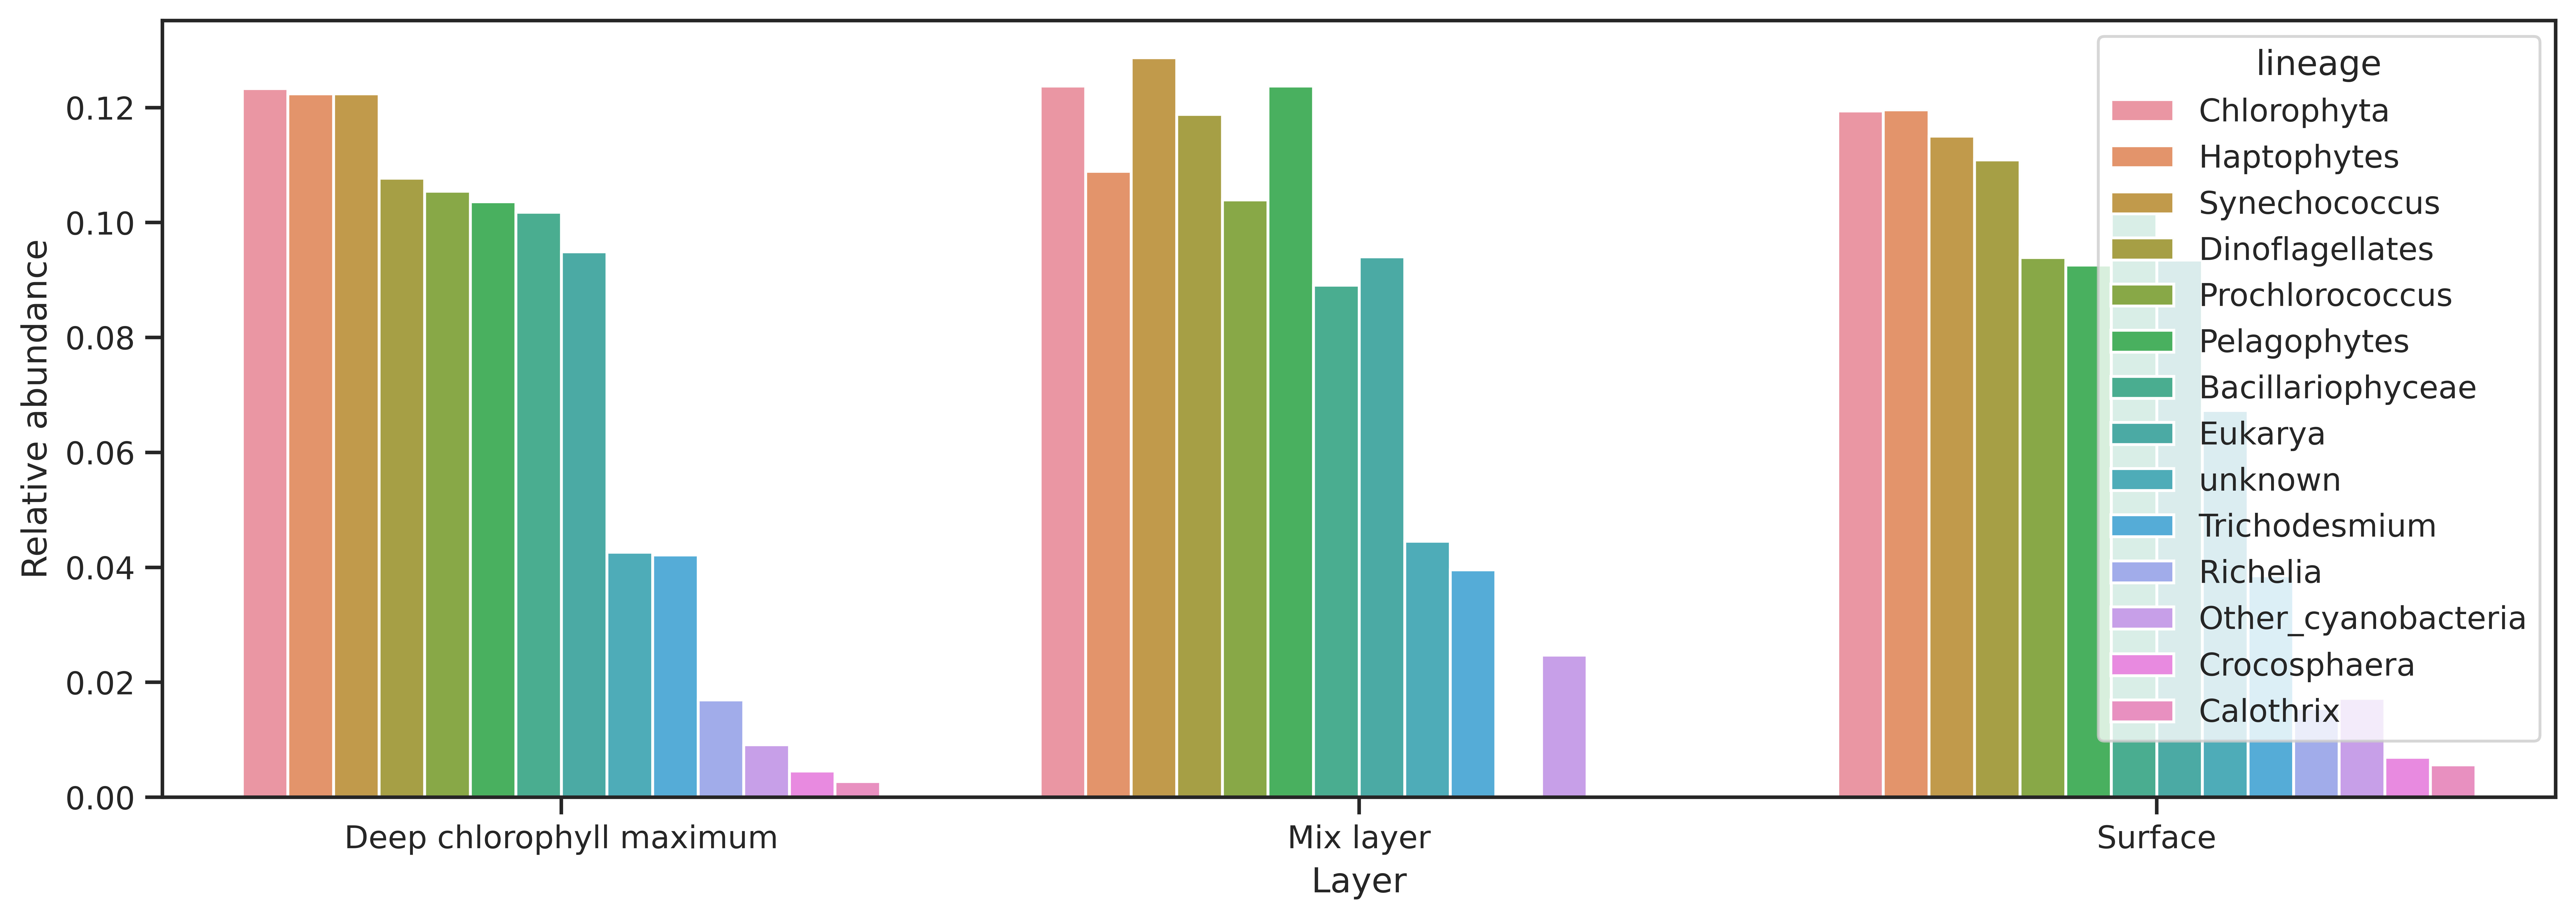

In [45]:
fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(ax=ax, y=0, x='Layer', hue='lineage', data=pd.concat(df_cont).T.reset_index())
ax.set_ylabel('Relative abundance')
fig.show()

Let's inspect the fasta file containing info on protein domains for the different species-specific psbO gene sequences.  
   - Goal: Learn structure of headers to properly formatting the new sequences

In [46]:
!echo 'Total No. sequences:'; grep -c '>' $psbO_db/peptide_seqs/NAD_binding_1.PfamRegion.faa
!echo ''
!echo 'Peeking at the fasta file...'
!echo ''
!head  -n 20  $psbO_db/peptide_seqs/NAD_binding_1.PfamRegion.faa

Total No. sequences:
67296

Peeking at the fasta file...

>MMETSP_CAMNT_0013045939_5__172-283 K00326|cytochrome-b5_reductase Eukaryota;Bacillariophyta;Coscinodiscophyceae;Thalassiosirophycidae;Thalassiosirales;Thalassiosiraceae;Detonula;Detonula confervacea, Strain CCMP 353
MIAGGTGITPMLQIMHAVLRDEPNSDVTVSLIYANQSEDDILVRQELEGAVEKYAGRFKLHYTVDNPPEGWKYSKGFITK
EMIQTHLPAVASDGSTQILMCGPPPMTKFACL
>MMETSP_CAMNT_0013045939_5__480-591 K00326|cytochrome-b5_reductase Eukaryota;Bacillariophyta;Coscinodiscophyceae;Thalassiosirophycidae;Thalassiosirales;Thalassiosiraceae;Detonula;Detonula confervacea, Strain CCMP 353
MIAGGTGITPMLQIMHAVLRDEPNSDVTVSLIYANQSEDDILVRQELEGAVEKYAGRFKLHYTVDNPPEGWKYSKGFITK
EMIQTHLPAVASDGSTQILMCGPPPMTKFACL
>MMETSP_CAMNT_0043566349_2__454-575 K02641|petH;ferredoxin--NADP+_reductase Eukaryota;Dinophyceae;Gonyaulacales;Gonyaulacaceae;Gonyaulax;Gonyaulax spinifera, Strain CCMP409
MLATGTGIAPMRSYIRLLFNDAAGAAADGSRKFKGLAWLFMGVPYSKSLLYDDEHVEYKAKYTDQFRYDYAVSREQTNAA
GQKMYIQTKMAEYTEELWELMQKPNT

<br>
<br>

### Now let's inspect the COI marker genes from [MZGdb](https://metazoogene.org/MZGdb) database for zooplankton species.   
**NOTE**: For a detailed description of DF headers check [here](https://www.st.nmfs.noaa.gov/nauplius/media/metazoogene/atlas/documentation/mzgdb-format.html)

In [5]:
coi_zooplankt_df = pd.read_csv("/kyukon/data/gent/vo/001/gvo00125/vsc43582/Bioinformatics/MetaPhlAn/Data/MZGdb/MZGdata-coi__MZGdbALL__o00__A.csv", header=None)

#Lets concentrate on organism name and corresponding COI sequence
min_coi_zooplankt_df = coi_zooplankt_df.iloc[:,[1,8,30]]
#Rename columns
#Use genebank accession to fetch a bunch of info needed to reformat headers
min_coi_zooplankt_df.columns = ["Species_name","Genebank_accession","Species_COI_seq"]
#Drop duplicate entries for genebank accessions
min_coi_zooplankt_df = min_coi_zooplankt_df.drop_duplicates(['Species_name'])

/tmp/ipykernel_3993655/1914633279.py:1: DtypeWarning: Columns (18,29) have mixed types. Specify dtype option on import or set low_memory=False.
  coi_zooplankt_df = pd.read_csv("/kyukon/data/gent/vo/001/gvo00125/vsc43582/Bioinformatics/MetaPhlAn/Data/MZGdb/MZGdata-coi__MZGdbALL__o00__A.csv", header=None)


### Run code below to create our plankton-specific MetaPhlan DB by gathering marker gene sequences (COI) from a great variety of zooplankton species

In [6]:
#Create dict of dicts for storing metadata for the metaphlan pickle file
custom_metaphl_db = {}
custom_metaphl_db['markers'] = {}
custom_metaphl_db['taxonomy'] = {}


#Set path to folder
metaphlan_db_folder = '/kyukon/data/gent/vo/001/gvo00125/vsc43582/Bioinformatics/MetaPhlAn/Data/metaphlan_databases'
#Set name for fasta file
new_fasta_fid = os.path.join(metaphlan_db_folder,'mpa_planktonic_CHOCOPhlAn_2022.fna')
new_pickle_fid = os.path.join(metaphlan_db_folder,'mpa_planktonic_CHOCOPhlAn_2022.pkl')


#Loop over sequences and modify fasta header format
for (n,ix) in enumerate(np.arange(min_coi_zooplankt_df.shape[0])):
    
    get_entry = min_coi_zooplankt_df.iloc[ix]
    
    #Now fetch fields necessary to modify header
    try: 
        ncbi_taxIDs_list, tax_ranks_list = format_tax_lbl(get_entry['Species_name'])

        genebank_id = get_entry['Genebank_accession']

        marker_gene_seq = get_entry['Species_COI_seq']

        tax_lineage = ("k__{}|p__{}|c__{}|o__{}|f__{}|g__{}|s__{}".format(*tax_ranks_list)).replace(" ","_")

        new_fasta_header = "{} UniRef90_undefined;{};GCA_undefined".format(genebank_id,tax_lineage)

        #Build a new SeqRecord obj
        seq_record = SeqRecord(Seq(get_entry['Species_COI_seq']), id='', name='', description=new_fasta_header)
        seq_record.description = seq_record.description.strip()
        #Next, build associted pkl file:
        custom_metaphl_db['markers'][genebank_id] = {
                                                    'clade': "s__{}".format(tax_lineage.split("|s__")[-1]),
                                                    'ext': [],
                                                    'len': len(get_entry['Species_COI_seq']),
                                                    'taxon': tax_lineage

        }
        custom_metaphl_db['taxonomy'][tax_lineage] = ("|".join(ncbi_taxIDs_list), 10000) #Note: field two (=10000) should be replaced by genome len!
        
        #Dump SeqRecord into a dedicated fasta file: our reference marker genes DB
        with open(new_fasta_fid, "a") as output_handle:
            bioseqio.write(seq_record, output_handle, "fasta")            

    except:
        pass 
    
#     if(n>10):
#         break

# Save our plankton-specific db as mpa_pkl file
with bz2.BZ2File(new_pickle_fid, 'w') as ofile:
    pickle.dump(custom_metaphl_db, ofile, pickle.HIGHEST_PROTOCOL)

###NOTE: To use the new database, run metaphlan.py with the "--index mpa_planktonic_CHOCOPhlAn_2022" parameter.

In [21]:
# #In case fasta file is wrongly formatted, re-run below

# metaphlan_db_folder = '/kyukon/data/gent/vo/001/gvo00125/vsc43582/Bioinformatics/MetaPhlAn/Data/metaphlan_databases'
# prev_fasta_fid = os.path.join(metaphlan_db_folder,'mpa_planktonic_CHOCOPhlAn_2022.fna')
# new_fasta_fid = os.path.join(metaphlan_db_folder,'new_mpa_planktonic_CHOCOPhlAn_2022.fna')

# with open(prev_fasta_fid, "r") as handle:
#     for (i,record) in enumerate(bioseqio.parse(handle, "fasta")):
#         record.description = record.description.strip()
#         with open(new_fasta_fid, "a") as output_handle:
#             bioseqio.write(record, output_handle, "fasta")

In [45]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [9]:
new_fasta_fid

'/kyukon/data/gent/vo/001/gvo00125/vsc43582/Bioinformatics/MetaPhlAn/Data/metaphlan_databases/mpa_planktonic_CHOCOPhlAn_2022.fna'

In [21]:
rnd_subsample_orgs = min_coi_zooplankt_df['Species_name'].sample(1000).values

In [ ]:
for org in rnd_subsample_orgs:
    id_doc_sum = get_sps_assembly_ncbi_summary(org)

    if not isinstance(id_doc_sum,list):

        #Assembly accession
        ass_id = id_doc_sum["AssemblyAccession"]

        #Grab metainfo
        meta_info = id_doc_sum["Meta"]

        #Parse metainfo and grab genome len in total num. of nucleotides
        ass_len = [f for f in meta_info.rsplit('<') if 'Stat category="total_length" sequence_tag="all">' in f][0].split(">")[-1]    

        print("Genome assembly len: {}, for : {}".format(ass_len, org))

Genome assembly len: 579633380, for : Botryllus schlosseri
Genome assembly len: 1347763624, for : Fasciola gigantica
Genome assembly len: 710793090, for : Caranx melampygus
Genome assembly len: 787309355, for : Sebastes rubrivinctus
Genome assembly len: 614147335, for : Istiophorus platypterus
Genome assembly len: 784640190, for : Sebastes carnatus
Genome assembly len: 520173038, for : Hoplostethus atlanticus
Genome assembly len: 801243942, for : Trachurus trachurus
Genome assembly len: 533267752, for : Beryx splendens
Genome assembly len: 393520168, for : Cassiopea xamachana
Genome assembly len: 615153901, for : Taurulus bubalis
Genome assembly len: 1003362100, for : Mugilogobius chulae
Genome assembly len: 1065596499, for : Chaenocephalus aceratus
Genome assembly len: 813246135, for : Sebastes iracundus
Genome assembly len: 3375698300, for : Chiloscyllium punctatum
Genome assembly len: 373990197, for : Lagocephalus sceleratus


In [19]:
 meta_info.rsplit('<')

[' ',
 'Stats> ',
 'Stat category="alt_loci_count" sequence_tag="all">0',
 '/Stat> ',
 'Stat category="chromosome_count" sequence_tag="all">0',
 '/Stat> ',
 'Stat category="contig_count" sequence_tag="all">116459',
 '/Stat> ',
 'Stat category="contig_l50" sequence_tag="all">26323',
 '/Stat> ',
 'Stat category="contig_n50" sequence_tag="all">3697',
 '/Stat> ',
 'Stat category="non_chromosome_replicon_count" sequence_tag="all">0',
 '/Stat> ',
 'Stat category="replicon_count" sequence_tag="all">0',
 '/Stat> ',
 'Stat category="scaffold_count" sequence_tag="all">95829',
 '/Stat> ',
 'Stat category="scaffold_count" sequence_tag="placed">0',
 '/Stat> ',
 'Stat category="scaffold_count" sequence_tag="unlocalized">0',
 '/Stat> ',
 'Stat category="scaffold_count" sequence_tag="unplaced">95829',
 '/Stat> ',
 'Stat category="scaffold_l50" sequence_tag="all">19034',
 '/Stat> ',
 'Stat category="scaffold_n50" sequence_tag="all">4932',
 '/Stat> ',
 'Stat category="total_length" sequence_tag="all">35

In [32]:
new_fasta_fid = os.path.join(metaphlan_db_folder,'mpa_planktonic_CHOCOPhlAn_2022.fna')
!head $new_fasta_fid -n 50

NameError: name 'metaphlan_db_folder' is not defined

### Check the pickle file created for the COI marker genes

In [5]:
metaphlan_db_folder = '/kyukon/data/gent/vo/001/gvo00125/vsc43582/Bioinformatics/MetaPhlAn/Data/metaphlan_databases'
new_pickle_fid = os.path.join(metaphlan_db_folder,'mpa_planktonic_CHOCOPhlAn_2022.pkl')

custom_db = pickle.load(bz2.open(new_pickle_fid, 'r'))
#Check keys
custom_db.keys()

dict_keys(['markers', 'taxonomy'])

Check how the markers key-associated data is structured

In [6]:
list(custom_db["markers"].items())[0]

('MT193877',
 {'clade': 's__Acanthochondria_ophidii',
  'ext': [],
  'len': 672,
  'taxon': 'k__Eukaryota|p__Arthropoda|c__Hexanauplia|o__Poecilostomatoida|f__Chondracanthidae|g__Acanthochondria|s__Acanthochondria_ophidii'})

Check how the taxonomy key-associated data is structured

In [55]:
list(custom_db["taxonomy"].items())[0]

('k__Eukaryota|p__Arthropoda|c__Hexanauplia|o__Poecilostomatoida|f__Chondracanthidae|g__Acanthochondria|s__Acanthochondria_ophidii',
 ('2759|6656|72037|84310|164116|1795191|2716289', 10000))

### Inspecting original marker genes DB used by default by MetaPhlan.  
Uncomment below to get a feeling of the data structure 

In [7]:
metaphl_db = '/data/gent/vo/001/gvo00125/vsc43582/Software/biobakery/lib/python3.7/site-packages/metaphlan/metaphlan_databases/'
db = pickle.load(bz2.open(os.path.join(metaphl_db,'mpa_v30_CHOCOPhlAn_201901.pkl'), 'r'))
db.keys()

dict_keys(['markers', 'taxonomy', 'merged_taxon'])

In [81]:
list(db["markers"].items())[600000]

('419650__A0A3D9UMD8__DFJ65_1485',
 {'clade': 's__Calidifontibacter_indicus',
  'ext': [],
  'len': 1284,
  'score': 0,
  'taxon': 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Dermacoccaceae|g__Calidifontibacter|s__Calidifontibacter_indicus'})

In [92]:
list(db["taxonomy"].items())[28700]

('k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_cereus_group|t__GCA_003367985',
 ('2|1239|91061|1385|186817|1386|86661', 4370506))